Other Examples: https://medium.com/@adriensieg/text-similarities-da019229c894

## 1. TF-Hub universal encoder

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
import seaborn as sns
import numpy as np

def inner_product(features):
    corr = np.inner(features[0], features[1])
    return corr

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(descriptions_, labels_):
    description_embeddings_ = embed(descriptions_)
    plot_similarity(labels_, description_embeddings_, 90)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10,10]

DIR = '/content/drive/MyDrive/teaching/courses_fall_2021/HCDS/network_viz_group_project/'

df = pd.read_csv(DIR + 'data/with desc/all_faculty_data.csv')

In [ ]:
df

,name,division,title,education,email,Research Areas,description,image
0,Tarek Abdoun,Engineering,Program Head of Civil Engineering; Professor o...,"PhD, Rensselaer Polytechnic Institute, NY",tarek.abdoun@nyu.edu,NaN,Professor Abdoun is the Thomas Iovino Chair Pr...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
1,Houssam Abdul Rahman,Science,Visiting Assistant Professor of Mathematics,BSc and MSc Jordan University of Science and T...,houssam.abdulrahman@nyu.edu,Mathematical Physics: Disordered Quantum Many ...,Houssam Abdul-Rahman's main research lies broa...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
2,Azza Abouzied,Science,Associate Professor of Computer Science,"BSc, MSc Dalhousie University; MPhil, PhD, Yal...",Azza@nyu.edu,Designing Intuitive Data Querying Tools,Azza Abouzied’s research work focuses on desig...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
3,Wifag Adnan,Social Science,Assistant Professor Economics,BS Duke University (magna cum laude with disti...,wa22@nyu.edu,Labor markets; Job search; Employment; Wage di...,Wifag Adnan’s research focuses on how labor ma...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
4,Ahmed Afzal,Science,Lecturer of Biology,"PhD Southern Illinois University, Postdoc The ...",aja11@nyu.edu,"Host-Pathogen Interactions, Prion Biology, Pro...",AJ Afzal is a plant molecular biologist by tra...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
...,...,...,...,...,...,...,...,...
339,Dania Zantout,Science,Lecturer of Mathematics,MS American University of Beirut; PhD Clemson ...,dz41@nyu.edu,"Automorphic forms, L-functions, Arithmetic Geo...",Dr. Dania Zantout earned her PhD in Mathematic...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
340,Ingyin Zaw,Science,Associate Professor of Physics,"AB, AM, and PhD in Physics from Harvard Univer...",ingyin.zaw@nyu.edu,"Particle Physics, Astronomy",Ingyin Zaw studies the intersection of particl...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
341,Weiren Zhao,Science,Assistant Professor of Mathematics,"BS, PhD Zhejiang University",wz19@nyu.edu,"Functional Analysis, Harmonic Analysis, PDEs, ...",Weiren Zhao earned his PhD from Zhejiang Unive...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...
342,William Zimmerle,Arts and Humanities,"Senior Lecturer, Arts and Humanities; Affiliat...",PhD University of Pennsylvania; MDiv Harvard U...,wgz1@nyu.edu,"Anthropology, Ethnography; Near Eastern and Ar...",William Gerard Zimmerle is both the Director o...,https://nyuad.nyu.edu/content/nyuad/en/home/ac...


In [ ]:
df_tag_wo_nan = df[df['Research Areas'].notna()].reset_index(drop=True)

- Checked that there is no duplicate!
- 17 faculties do not have specified research areas

In [ ]:
tag_embeddings = embed(df_tag_wo_nan['Research Areas'])

In [ ]:
df_tag_wo_nan['tag_embeddings'] = tag_embeddings

In [ ]:
df_tag_wo_nan = df_tag_wo_nan.sort_values('division', ascending=True).reset_index(drop=True)

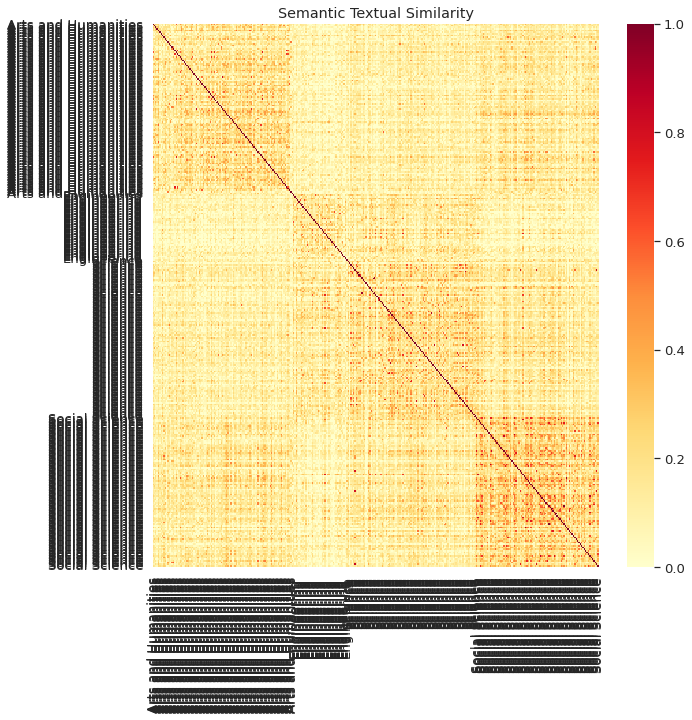

In [ ]:
plot_similarity(df_tag_wo_nan['division'], list(df_tag_wo_nan['tag_embeddings']), 90)

In [ ]:
from itertools import combinations

name_combination = list(combinations(df_tag_wo_nan['name'],2))

In [ ]:
#-Combinations without repetition = 53301
len(name_combination)

53301

In [ ]:
d_name_embed = pd.Series(df_tag_wo_nan['tag_embeddings'].values, index=df_tag_wo_nan['name']).to_dict()

In [ ]:
l_i = []
l_j = []
l_w = []
for i in name_combination:
  l_i.append(i[0])
  l_j.append(i[1])
  l_w.append(inner_product((d_name_embed[i[0]],d_name_embed[i[1]])))

In [ ]:
df_dyads = pd.DataFrame(
    {'node_i': l_i,
     'node_j': l_j,
     'weight': l_w
    })

In [ ]:
df_dyads['weight'].describe()

count    53301.000000
mean         0.137247
std          0.115132
min         -0.175284
25%          0.059909
50%          0.122017
75%          0.195865
max          1.000000
Name: weight, dtype: float64

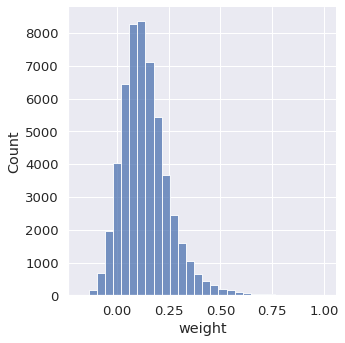

In [ ]:
sns.displot(df_dyads, x='weight', bins=30)

In [ ]:
import networkx
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community

In [ ]:
output_notebook()

In [ ]:
# Serrano, Boguna, Vespigani backbone extractor
# from http://www.pnas.org/content/106/16/6483.abstract
# Thanks to Michael Conover and Qian Zhang at Indiana with help on earlier versions
# Thanks to Clay Davis for pointing out an error

from scipy import integrate

def extract_backbone(g, alpha):
  backbone_graph = networkx.Graph()
  for node in g:
      k_n = len(g[node])
      if k_n > 1:
          sum_w = sum( g[node][neighbor]['weight'] for neighbor in g[node] )
          for neighbor in g[node]:
              edgeWeight = g[node][neighbor]['weight']
              pij = float(edgeWeight)/sum_w
              if (1-pij)**(k_n-1) < alpha: # equation 2
                  backbone_graph.add_edge( node,neighbor, weight = edgeWeight)
  return backbone_graph

In [ ]:
G = networkx.from_pandas_edgelist(df_dyads, 'node_i', 'node_j', 'weight')

In [ ]:
#Choose a title!
title = 'The Landscape of Academic Interests at NYUAD'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Name", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# ttps://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [ ]:
G_backbone = extract_backbone(G, 0.05)

In [ ]:
len(G_backbone)

326

In [ ]:
#Choose a title!
title = 'The Landscape of Academic Interests at NYUAD'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Name", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
#https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_backbone, networkx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [ ]:
degrees = dict(networkx.degree(G_backbone))
networkx.set_node_attributes(G_backbone, name='degree', values=degrees)

In [ ]:
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G_backbone)])
networkx.set_node_attributes(G_backbone, name='adjusted_node_size', values=adjusted_node_size)

In [ ]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'The Landscape of Academic Interests at NYUAD'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
                  ("Name", "@index"),
                  ("Degree", "@degree")
                  ]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
#https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G_backbone, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [ ]:
d_division_name = pd.Series(df_tag_wo_nan['division'].values, index=df_tag_wo_nan['name']).to_dict()

d_division_idx = {v:idx for idx,v in enumerate(df_tag_wo_nan['division'].unique())}
d_division_color = {}
for name in d_division_name:
  d_division_color[name] = Spectral8[d_division_idx[d_division_name[name]]]

In [ ]:
# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G_backbone, d_division_name, 'division_class')
networkx.set_node_attributes(G_backbone, d_division_color, 'division_color')

In [ ]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'division_color'
#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8
#Choose a title!
title = 'The Landscape of Academic Interests at NYUAD'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
                  ("Name", "@index"),
                  ("Degree", "@degree"),
                  ("Division Class", "@division_class"),
                  ("Division Color", "$color[swatch]:division_color")
                  ]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
#https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_backbone, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [ ]:
communities = community.greedy_modularity_communities(G_backbone)

In [ ]:
len(communities)

5

In [ ]:
# Create empty dictionaries
modularity_class = {}
modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    for name in community: 
        modularity_class[name] = community_number
        modularity_color[name] = Spectral8[community_number]

In [ ]:
# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G_backbone, modularity_class, 'modularity_class')
networkx.set_node_attributes(G_backbone, modularity_color, 'modularity_color')

In [ ]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'
#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8
#Choose a title!
title = 'The Landscape of Academic Interests at NYUAD'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Name", "@index"),
                  ("Degree", "@degree"),
                  ("Modularity Class", "@modularity_class"),
                  ("Modularity Color", "$color[swatch]:modularity_color"),
                  ("Division Class", "@division_class")
                  ]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,
              width=1200, height=1200)

#Create a network graph object
#https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_backbone, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [ ]:
#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'The Landscape of Academic Interests at NYUAD'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Name", "@index"),
                  ("Degree", "@degree"),
                  ("Modularity Class", "@modularity_class"),
                  ("Modularity Color", "$color[swatch]:modularity_color"),
                  ("Division Class", "@division_class")
                  ]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,
              width=1200, height=1200)

#Create a network graph object
#https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_backbone, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

#Add Labels
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G_backbone.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)

show(plot)
#save(plot, filename=f"{title}.html")